In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
# Ensure reproducibility
torch.manual_seed(0)
random.seed(0)

In [33]:
# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [34]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\momos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\momos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\momos\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [35]:
# Initialize NLTK tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [36]:
def preprocess_text(text, remove_stopwords):
    """Tokenize, optionally remove stop words, lemmatize, and clean text."""
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalpha()]
    if remove_stopwords:
        words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return words

In [37]:
def load_and_preprocess_text(file_path, remove_stopwords, sampling_ratio=0.0125):
    """Load text from a file, preprocess, and sample it."""
    with open('HP1.txt', 'r', encoding='utf-8') as f:
        text = f.read()
    words = preprocess_text(text, remove_stopwords=remove_stopwords)
    return words[:int(len(words) * sampling_ratio)]

In [38]:
def create_vocabulary(words):
    """Create vocabulary and mapping dictionaries."""
    vocab = sorted(set(words))
    word_to_index = {word: i for i, word in enumerate(vocab)}
    index_to_word = {i: word for i, word in enumerate(vocab)}
    return vocab, word_to_index, index_to_word

In [39]:
def one_hot_vector(word_index, vocab_size):
    """Generate a one-hot encoded vector."""
    vector = torch.zeros(vocab_size, device=device)
    vector[word_index] = 1
    return vector

In [40]:
def generate_training_data(words, word_to_index, window_size=2):
    """Generate input-output pairs for training."""
    vocab_size = len(word_to_index)
    training_data = []
    for i, word in enumerate(words):
        if word not in word_to_index:
            continue
        input_word = word_to_index[word]
        input_vector = one_hot_vector(input_word, vocab_size)
        for j in range(-window_size, window_size + 1):
            if j != 0 and 0 <= i + j < len(words):
                if words[i + j] not in word_to_index:
                    continue
                output_word = word_to_index[words[i + j]]
                output_vector = one_hot_vector(output_word, vocab_size)
                training_data.append((input_vector, output_vector))
    return training_data

In [41]:
class Word2VecDataset(Dataset):
    """Custom dataset for Word2Vec training data."""

    def __init__(self, training_data):
        self.training_data = training_data

    def __len__(self):
        return len(self.training_data)

    def __getitem__(self, idx):
        return self.training_data[idx]

In [42]:
class Word2Vec(nn.Module):
    """Simple Word2Vec model with one hidden layer."""

    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.embeddings = nn.Linear(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, input_vector):
        embed = self.embeddings(input_vector)
        output = self.linear(embed)
        return output

    def get_embedding(self, input_vector):
        with torch.no_grad():
            embed = self.embeddings(input_vector)
        return embed

In [43]:
def train_word2vec_model(train_loader, model, epochs=100, lr=0.01):
    """Train the Word2Vec model."""
    optimizer = optim.SGD(model.parameters(), lr=lr)
    loss_function = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0
        for input_vector, output_vector in train_loader:
            optimizer.zero_grad()
            output = model(input_vector)
            loss = loss_function(output, output_vector)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(
                f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}')

In [44]:
def save_word2vec_model(model, file_path):
    """Save the trained Word2Vec model."""
    torch.save(model.state_dict(), file_path)
    print(f"Model saved to {file_path}")

In [45]:
def load_word2vec_model(file_path, vocab_size, embedding_dim):
    """Load a saved Word2Vec model."""
    model = Word2Vec(vocab_size, embedding_dim)
    model.load_state_dict(torch.load(file_path))
    model.to(device)
    model.eval()  # Set model to evaluation mode
    print(f"Model loaded from {file_path}")
    return model

In [46]:
def get_word_embedding(word, model, word_to_index):
    """Retrieve the embedding for a given word."""
    input_vector = one_hot_vector(
        word_to_index[word], len(word_to_index)).unsqueeze(0)
    embedding = model.get_embedding(input_vector).squeeze(0)
    return embedding

In [47]:
def infer_embedding_from_one_hot(one_hot_vector, model):
    """
    Given a 1-hot vector, return the corresponding word embedding using the trained model.

    Args:
        one_hot_vector (torch.Tensor): A 1-hot encoded vector of size [vocab_size].
        model (Word2Vec): The trained Word2Vec model.

    Returns:
        torch.Tensor: The corresponding embedding vector.
    """
    one_hot_vector = one_hot_vector.to(
        device)  # Ensure the vector is on the correct device
    embedding = model.get_embedding(one_hot_vector.unsqueeze(0)).squeeze(0)
    return embedding

In [48]:
def sentence_to_vec(sentence, model, word_to_index):
    """Convert a sentence to a vector by averaging word embeddings."""
    words = word_tokenize(sentence.lower())
    word_vectors = [get_word_embedding(word, model, word_to_index).cpu().numpy()
                    for word in words if word in word_to_index]

    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.embeddings.out_features)

In [49]:
def create_synthetic_dataset():
    """Create a larger synthetic dataset for text classification."""
    return [
        # Magic examples
        ("harry potter is a wizard", "magic"),
        ("harry casts a powerful spell", "magic"),
        ("hogwarts is a school of witchcraft and wizardry", "magic"),
        ("hermione granger is an intelligent witch", "magic"),
        ("ron weasley is harry's best friend", "magic"),
        ("dumbledore is a powerful wizard", "magic"),
        ("professor snape teaches potions at hogwarts", "magic"),
        ("the sorting hat decides the houses", "magic"),
        ("quidditch is a popular magical sport", "magic"),
        ("the invisibility cloak is a rare magical artifact", "magic"),
        ("harry speaks with snakes due to his parseltongue ability", "magic"),
        ("the marauder's map reveals everyone's location at hogwarts", "magic"),
        ("harry practices magic at hogwarts", "magic"),
        ("sirius black escapes from azkaban using magic", "magic"),
        ("the elder wand is the most powerful wand in existence", "magic"),
        ("hermione uses a time turner to attend multiple classes", "magic"),
        ("the patronus charm wards off dementors", "magic"),
        ("harry defeats voldemort using the power of love", "magic"),
        ("the triwizard tournament is a dangerous magical competition", "magic"),
        ("hagrid is the keeper of keys and grounds at hogwarts", "magic"),
        ("the philosopher's stone grants immortality", "magic"),
        ("fawkes, dumbledore's phoenix, has healing tears", "magic"),
        ("the chamber of secrets is hidden beneath hogwarts", "magic"),
        ("the resurrection stone can bring back the dead temporarily", "magic"),
        ("professor mcgonagall can transform into a cat", "magic"),
        ("the room of requirement appears when needed", "magic"),
        ("the basilisk is a giant serpent that petrifies students", "magic"),
        ("harry's scar hurts when voldemort is near", "magic"),
        ("voldemort splits his soul into horcruxes", "magic"),
        ("polyjuice potion allows the drinker to assume another's form", "magic"),
        
        # Muggle examples
        ("dursley family is non magical", "muggle"),
        ("dudley dursley is a bully", "muggle"),
        ("the dursleys live at number four privet drive", "muggle"),
        ("uncle vernon works at a drill company", "muggle"),
        ("aunt petunia is obsessed with normality", "muggle"),
        ("dudley attends a private school called smeltings", "muggle"),
        ("the dursleys despise anything unusual", "muggle"),
        ("dudley is spoiled by his parents", "muggle"),
        ("marge dursley is vernon's sister", "muggle"),
        ("the dursleys are terrified of magic", "muggle"),
        ("the dursleys lock harry in the cupboard under the stairs", "muggle"),
        ("the dursleys go on a family vacation without harry", "muggle"),
        ("harry was raised by the dursleys", "muggle"),
        ("petunia was jealous of her sister's magical abilities", "muggle"),
        ("the dursleys refuse to acknowledge harry's magical talents", "muggle"),
        ("dudley and his gang bully other kids", "muggle"),
        ("vernon dursley is the director of a firm called grunnings", "muggle"),
        ("the dursleys move to a small island to avoid harry's letters", "muggle"),
        ("the dursleys enjoy watching television", "muggle"),
        ("harry is treated like a servant by the dursleys", "muggle"),
        ("dudley often throws tantrums to get what he wants", "muggle"),
        ("the dursleys have a strict routine and dislike surprises", "muggle"),
        ("the dursleys are proud of being ordinary", "muggle"),
        ("the dursleys have a pet dog named rippy", "muggle"),
        ("the dursleys are horrified when harry receives his hogwarts letter", "muggle"),
        ("dudley complains about his diet during the summer", "muggle"),
        ("the dursleys try to keep harry's magical abilities a secret", "muggle"),
        ("vernon dursley is often angry and red-faced", "muggle"),
        ("the dursleys do not celebrate harry's birthday", "muggle"),
        ("petunia dursley is overly concerned with appearances", "muggle"),
    ]


In [50]:
def prepare_features_and_labels(data, model, word_to_index, label_to_index):
    """Prepare feature vectors and labels for classification."""
    X = np.array([sentence_to_vec(sentence, model, word_to_index)
                 for sentence, _ in data])
    y = np.array([label_to_index[label] for _, label in data])
    return X, y

In [51]:
def train_and_evaluate_classifier(X_train, y_train, X_test, y_test, index_to_label):
    """Train a classifier and evaluate its performance."""
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=index_to_label.values(),
                yticklabels=index_to_label.values())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [52]:
# Load and preprocess text data
sampled_words_without_stop = load_and_preprocess_text('HP1.txt', remove_stopwords=True, sampling_ratio=0.0125)
sampled_words_with_stop = load_and_preprocess_text('HP1.txt', remove_stopwords=False, sampling_ratio=0.0125)
print(f"Number of words in text without stop: {len(sampled_words_without_stop)}")
print(f"Sampled words in text without stop: {sampled_words_without_stop[:10]}")

print(f"Number of words in text with stop: {len(sampled_words_with_stop)}")
print(f"Sampled words in text with stop: {sampled_words_with_stop[:10]}")

Number of words in text without stop: 495
Sampled words in text without stop: ['dursley', 'number', 'four', 'privet', 'drive', 'proud', 'say', 'perfectly', 'normal', 'thank']
Number of words in text with stop: 989
Sampled words in text with stop: ['and', 'dursley', 'of', 'number', 'four', 'privet', 'drive', 'were', 'proud', 'to']


In [53]:
# Create vocabulary and mappings
vocab_without_stop, word_to_index_without_stop, index_to_word_without_stop = create_vocabulary(sampled_words_without_stop)
print(f"Vocabulary size without stop: {len(vocab_without_stop)}")
print(f"Sampled vocabulary without stop: {vocab_without_stop[:10]}")

vocab_with_stop, word_to_index_with_stop, index_to_word_with_stop = create_vocabulary(sampled_words_with_stop)
print(f"Vocabulary size with stop: {len(vocab_with_stop)}")
print(f"Sampled vocabulary with stop: {vocab_with_stop[:10]}")



Vocabulary size without stop: 324
Sampled vocabulary without stop: ['across', 'almost', 'also', 'although', 'always', 'amount', 'angrily', 'another', 'anyone', 'anything']
Vocabulary size with stop: 390
Sampled vocabulary with stop: ['a', 'about', 'across', 'after', 'again', 'all', 'also', 'although', 'always', 'amount']


In [54]:
# Generate training data
training_data_without_stop = generate_training_data(sampled_words_without_stop, word_to_index_without_stop)
print(f"Number of training samples without stop: {len(training_data_without_stop)}")

training_data_with_stop = generate_training_data(sampled_words_with_stop, word_to_index_with_stop)
print(f"Number of training samples with stop: {len(training_data_with_stop)}")

Number of training samples without stop: 1974
Number of training samples with stop: 3950


In [55]:
# Create DataLoader for batch processing
train_loader_without_stop = DataLoader(Word2VecDataset(training_data_without_stop), batch_size=64, shuffle=True)

train_loader_with_stop = DataLoader(Word2VecDataset(training_data_with_stop), batch_size=64, shuffle=True)

In [56]:
# Initialize and train Word2Vec model
embedding_dim = 100

model_without_stop = Word2Vec(len(vocab_without_stop), embedding_dim).to(device)
train_word2vec_model(train_loader_without_stop, model_without_stop, epochs=100, lr=0.01)

model_with_stop = Word2Vec(len(vocab_with_stop), embedding_dim).to(device)
train_word2vec_model(train_loader_with_stop, model_with_stop, epochs=100, lr=0.01)

Epoch 10/100, Loss: 0.00697172500733887
Epoch 20/100, Loss: 0.006762528251255712
Epoch 30/100, Loss: 0.006569579559107942
Epoch 40/100, Loss: 0.006389864074486879
Epoch 50/100, Loss: 0.006223133990481015
Epoch 60/100, Loss: 0.006067483761017361
Epoch 70/100, Loss: 0.005922789760534802
Epoch 80/100, Loss: 0.00578789776491542
Epoch 90/100, Loss: 0.005661305956422321
Epoch 100/100, Loss: 0.0055423639264077906
Epoch 10/100, Loss: 0.006452154751206117
Epoch 20/100, Loss: 0.006136478751056617
Epoch 30/100, Loss: 0.005855195667414415
Epoch 40/100, Loss: 0.005602318440533934
Epoch 50/100, Loss: 0.005374775538521428
Epoch 60/100, Loss: 0.005169181153178215
Epoch 70/100, Loss: 0.004982189590772314
Epoch 80/100, Loss: 0.004812435615026663
Epoch 90/100, Loss: 0.004657313242674836
Epoch 100/100, Loss: 0.004515580344764936


In [57]:
# Save the trained model
save_word2vec_model(model_without_stop, "word2vec_model_without_stop.pth")
save_word2vec_model(model_with_stop, "word2vec_model_with_stop.pth")

Model saved to word2vec_model_without_stop.pth
Model saved to word2vec_model_with_stop.pth


In [58]:
# Example: Inference from a 1-hot vector (without_stop)
word = "harry"
if word in word_to_index_without_stop:
    one_hot_vec = one_hot_vector(word_to_index_without_stop[word], len(vocab_without_stop))
    embedding = infer_embedding_from_one_hot(one_hot_vec, model_without_stop)
    print(f"Embedding for '{word}': {embedding.cpu().numpy()}")
else:
    print(f"Word '{word}' not found in vocabulary.")

Embedding for 'harry': [ 0.03844901  0.04543697 -0.10878    -0.02555934  0.07402951 -0.04952545
  0.0004124  -0.06997204 -0.03512633 -0.01290623 -0.01885929  0.03998341
 -0.06191524  0.06610629 -0.01866924  0.04110705 -0.05259521  0.01614056
 -0.00946887  0.07316788 -0.0122979   0.02658844 -0.02229108  0.05793237
 -0.01493399 -0.00527312 -0.01393625 -0.00695427 -0.05991523 -0.00702011
 -0.0394148   0.08519608 -0.00624298 -0.01891657  0.02350362  0.02489071
  0.01965818  0.08014542  0.05434592  0.00728782 -0.01340918 -0.00017994
  0.05786791  0.08546393 -0.03977128  0.00401897  0.00770041  0.05377323
 -0.03566595 -0.00536143  0.00857709 -0.04957271  0.03999159 -0.00153912
  0.00709397 -0.03313319  0.01069032  0.00771775  0.01048747  0.04729463
  0.04601784 -0.02208117  0.00640398  0.05680246 -0.06639124  0.0895108
 -0.07530437 -0.0123159   0.04036394 -0.05268839  0.0235489   0.05334887
 -0.06816702  0.05426363  0.01791198 -0.06061008 -0.02862433 -0.02712588
  0.00361222  0.01008274 -0.0

In [59]:
# Example: Inference from a 1-hot vector (with_stop)

word = "harry"
if word in word_to_index_with_stop:
    one_hot_vec = one_hot_vector(word_to_index_with_stop[word], len(vocab_with_stop))
    embedding = infer_embedding_from_one_hot(one_hot_vec, model_with_stop)
    print(f"Embedding for '{word}': {embedding.cpu().numpy()}")
else:
    print(f"Word '{word}' not found in vocabulary.")

Embedding for 'harry': [-0.0530783   0.01762675 -0.01125533  0.02734794 -0.02093221 -0.03450192
  0.05482077 -0.01661431  0.01278769 -0.03893923  0.03971538  0.00943485
 -0.03873069 -0.03451888  0.0431224  -0.01271079  0.00442901 -0.04123817
 -0.0775761  -0.0635734   0.0398122   0.01825161 -0.02459295  0.07275625
 -0.00332657 -0.03791375 -0.04944352 -0.04288843 -0.00991016  0.04124469
  0.00960298  0.06847268 -0.01473995  0.06783885 -0.00434509 -0.03188606
  0.03922448 -0.03071676 -0.00927286  0.05137883  0.03388418  0.02183873
 -0.05477878  0.03978537  0.02440173  0.03932498  0.01373984 -0.0157092
 -0.07738337 -0.06915791  0.00368755 -0.04359275 -0.01752132 -0.02312266
  0.03441559 -0.0133285  -0.06339757  0.05018494  0.00889457  0.01020909
 -0.0190822  -0.0403847   0.04386631  0.00298234 -0.08565012  0.0217104
  0.07500107 -0.01166157 -0.01374042  0.02431092 -0.02638808  0.0441052
 -0.01096517 -0.01136899 -0.06566121  0.00250013  0.02631466  0.02906191
  0.02241355  0.03821819  0.064

In [60]:
# Load the saved model (optional, just to demonstrate loading)
loaded_model_without_stop = load_word2vec_model("word2vec_model_without_stop.pth", len(vocab_without_stop), embedding_dim)

loaded_model_with_stop = load_word2vec_model("word2vec_model_with_stop.pth", len(vocab_with_stop), embedding_dim)

Model loaded from word2vec_model_without_stop.pth
Model loaded from word2vec_model_with_stop.pth


/var/folders/33/690z1r7d4zd6hsk_3_12g2_m0000gn/T/ipykernel_34599/1035760200.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path))


In [61]:
# Create and process synthetic dataset for classification (without stop)
data = create_synthetic_dataset()
label_to_index = {"magic": 0, "muggle": 1}
index_to_label = {v: k for k, v in label_to_index.items()}
X, y = prepare_features_and_labels(data, loaded_model_without_stop, word_to_index_without_stop, label_to_index)

Test Accuracy: 0.8889


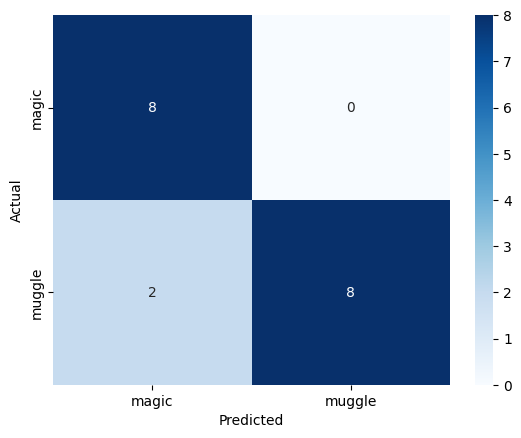

In [62]:
# Split data and evaluate classifier (without stop)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
train_and_evaluate_classifier(X_train, y_train, X_test, y_test, index_to_label)

In [63]:
# Create and process synthetic dataset for classification (with stop)
data = create_synthetic_dataset()
label_to_index = {"magic": 0, "muggle": 1}
index_to_label = {v: k for k, v in label_to_index.items()}
X, y = prepare_features_and_labels(data, loaded_model_with_stop, word_to_index_with_stop, label_to_index)

Test Accuracy: 0.4444


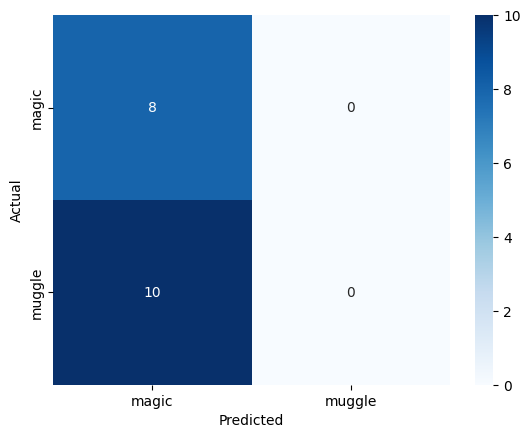

In [64]:
# Split data and evaluate classifier (with stop)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
train_and_evaluate_classifier(X_train, y_train, X_test, y_test, index_to_label)